# MuTrans analysis: cisplatin

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pyMuTrans as pm
import hdf5plugin
import gc
import seaborn as sns

sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')

datadir = "data/"

In [2]:
adata = sc.read(datadir+'cis_anndata.h5ad')
adata

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 4474 × 17550
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Barcode', 'Batch', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'Graph.Cluster', 'ClusterLabel', 'detected', 'total', 'subsets_mt_percent', 'subsets_ribo_percent', 'subsets_linc_percent', 'Seurat.Phase', 'Seurat.S', 'Seurat.G2M', 'Cyclone.Phase', 'Cyclone.G1', 'Cyclone.S', 'Cyclone.G2M', 'Tricycle.Phase', 'Tricycle.Position', 'Seurat.Cycle.Score', 'nCount_SCT', 'nFeature_SCT', 'snn_res.0.2', 'seurat_clusters.0.2', 'snn_res.0.4', 'seurat_clusters.0.4', 'snn_res.0.6', 'seurat_clusters.0.6', 'snn_res.0.8', 'seurat_clusters.0.8', 'snn_res.1', 'seurat_clusters.1', 'snn_res.1.2', 'seurat_clusters.1.2', 'snn_res.1.4', 'seurat_clusters.1.4', 'snn_res.1.6', 'seurat_clusters.1.6', 'snn_res.1.8', 'seurat_clusters.1.8', 'snn_res.2', 'seurat_clusters.2', 'MES.Sig', 'ADRN.Sig', 'AMT.Sig', 'Test_Clusters', 'Inter.Sig', 'Coexprs.Sig', 'Noncoexprs.Sig', 'MESclust.Sig', 'ADRNclus

In [3]:
adata.obs = adata.obs[['Sample', 'Barcode', 'Batch', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.Sig']]
adata.obsm = []
adata

AnnData object with n_obs × n_vars = 4474 × 17550
    obs: 'Sample', 'Barcode', 'Batch', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.Sig'
    layers: 'logcounts'

## Pre-processing
See: https://scanpy.readthedocs.io/en/stable/tutorials.html

Quick QC

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

Normalisation

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

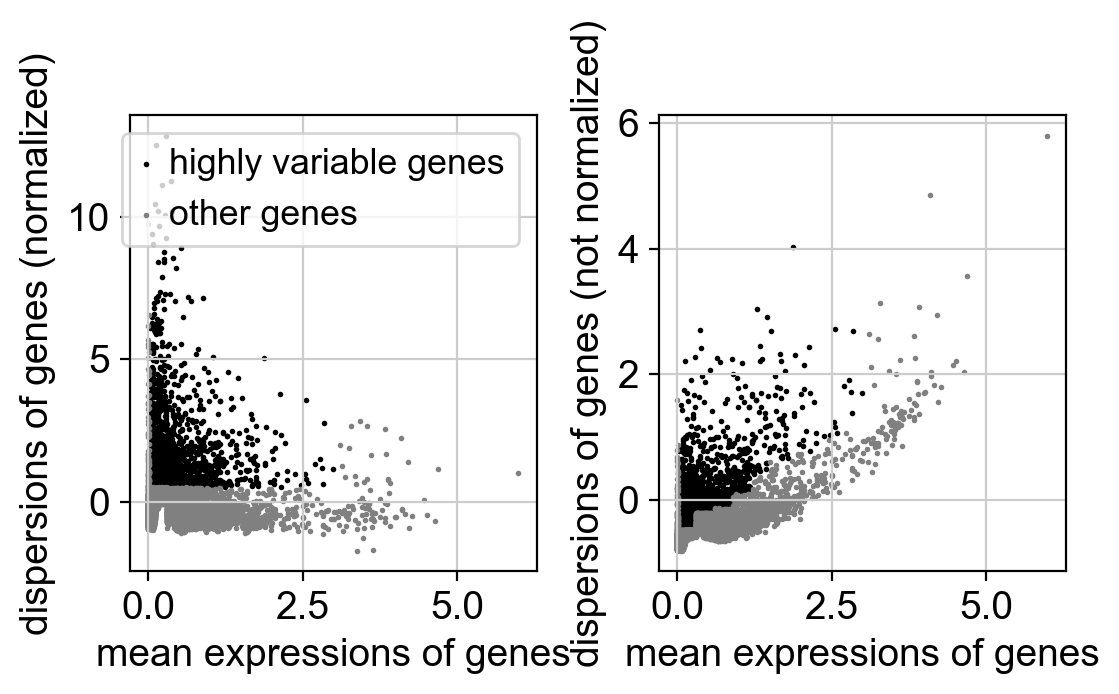

In [6]:
sc.pl.highly_variable_genes(adata)

In [7]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [8]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [9]:
sc.pp.scale(adata, max_value=10)

Reduced dims

In [10]:
sc.tl.pca(adata, svd_solver='arpack')

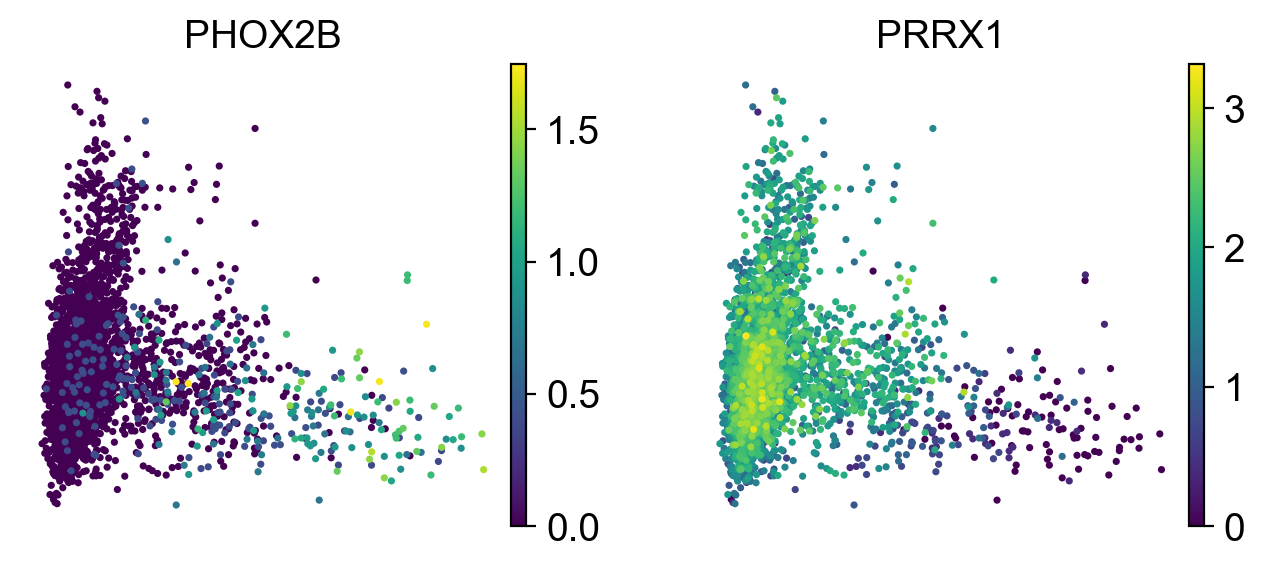

In [11]:
sc.pl.pca(adata, color=['PHOX2B','PRRX1'])

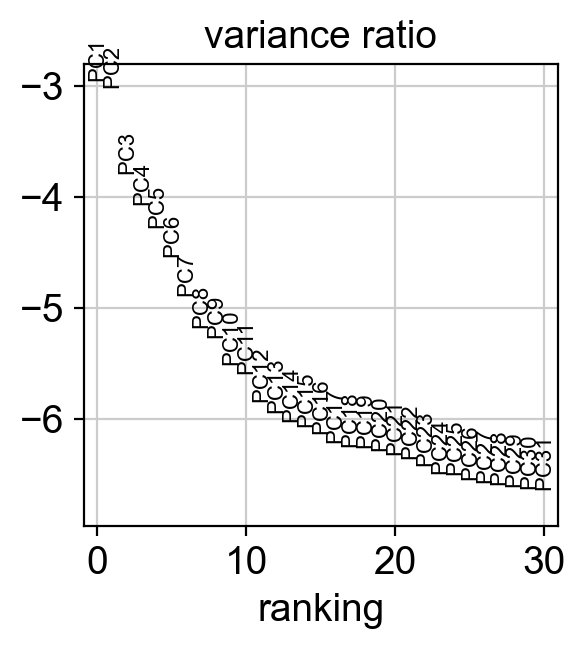

In [12]:
sc.pl.pca_variance_ratio(adata, log=True)

In [13]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1086: NumbaD

In [14]:
sc.tl.umap(adata)

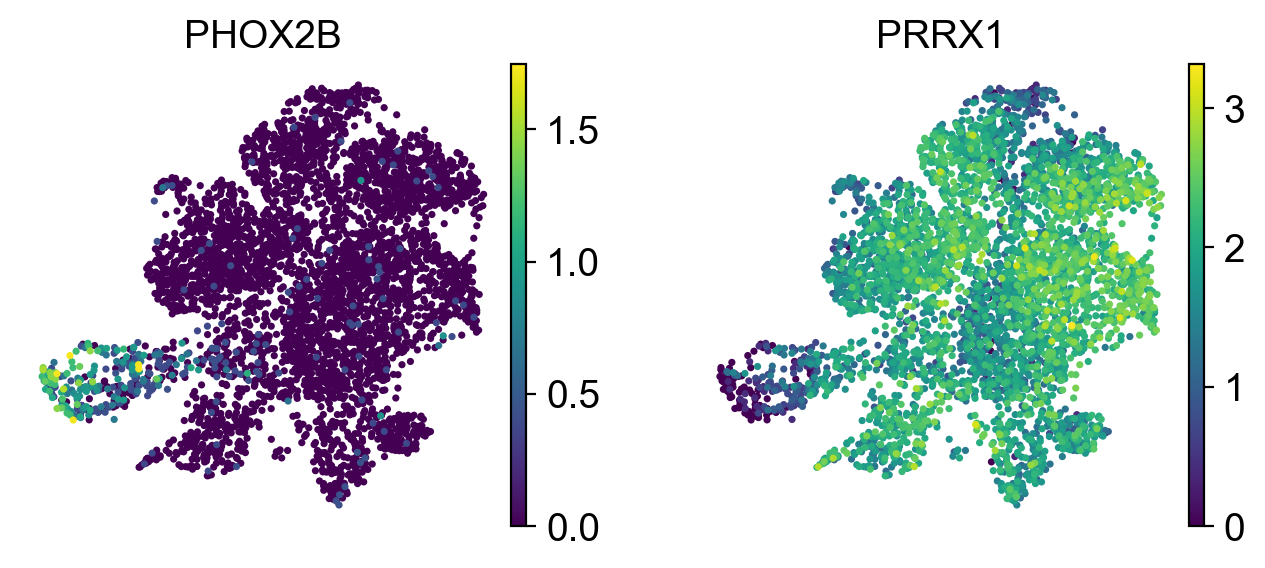

In [15]:
sc.pl.umap(adata, color=['PHOX2B','PRRX1'])

Clustering

In [16]:
sc.tl.leiden(adata, resolution = 0.2)

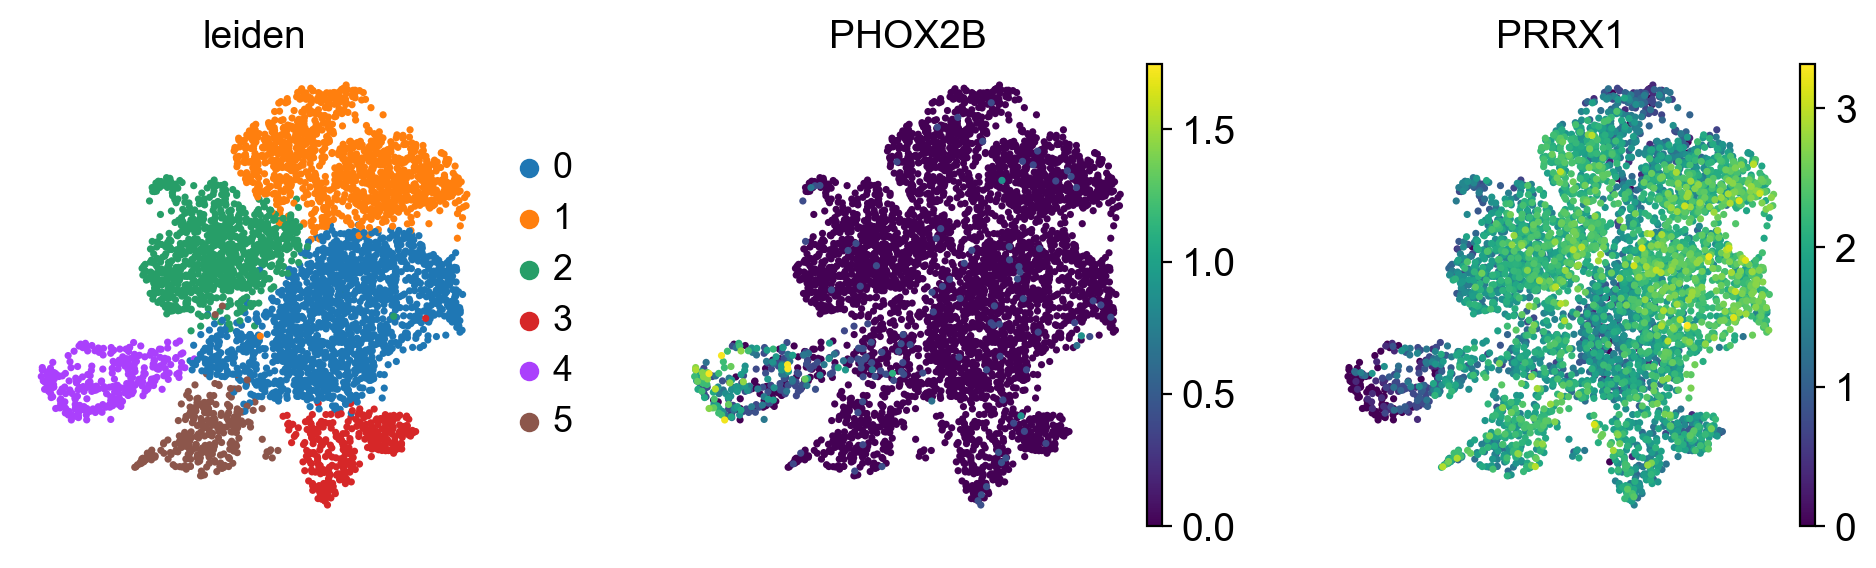

In [17]:
sc.pl.umap(adata, color=['leiden', 'PHOX2B', 'PRRX1'])

Marker genes

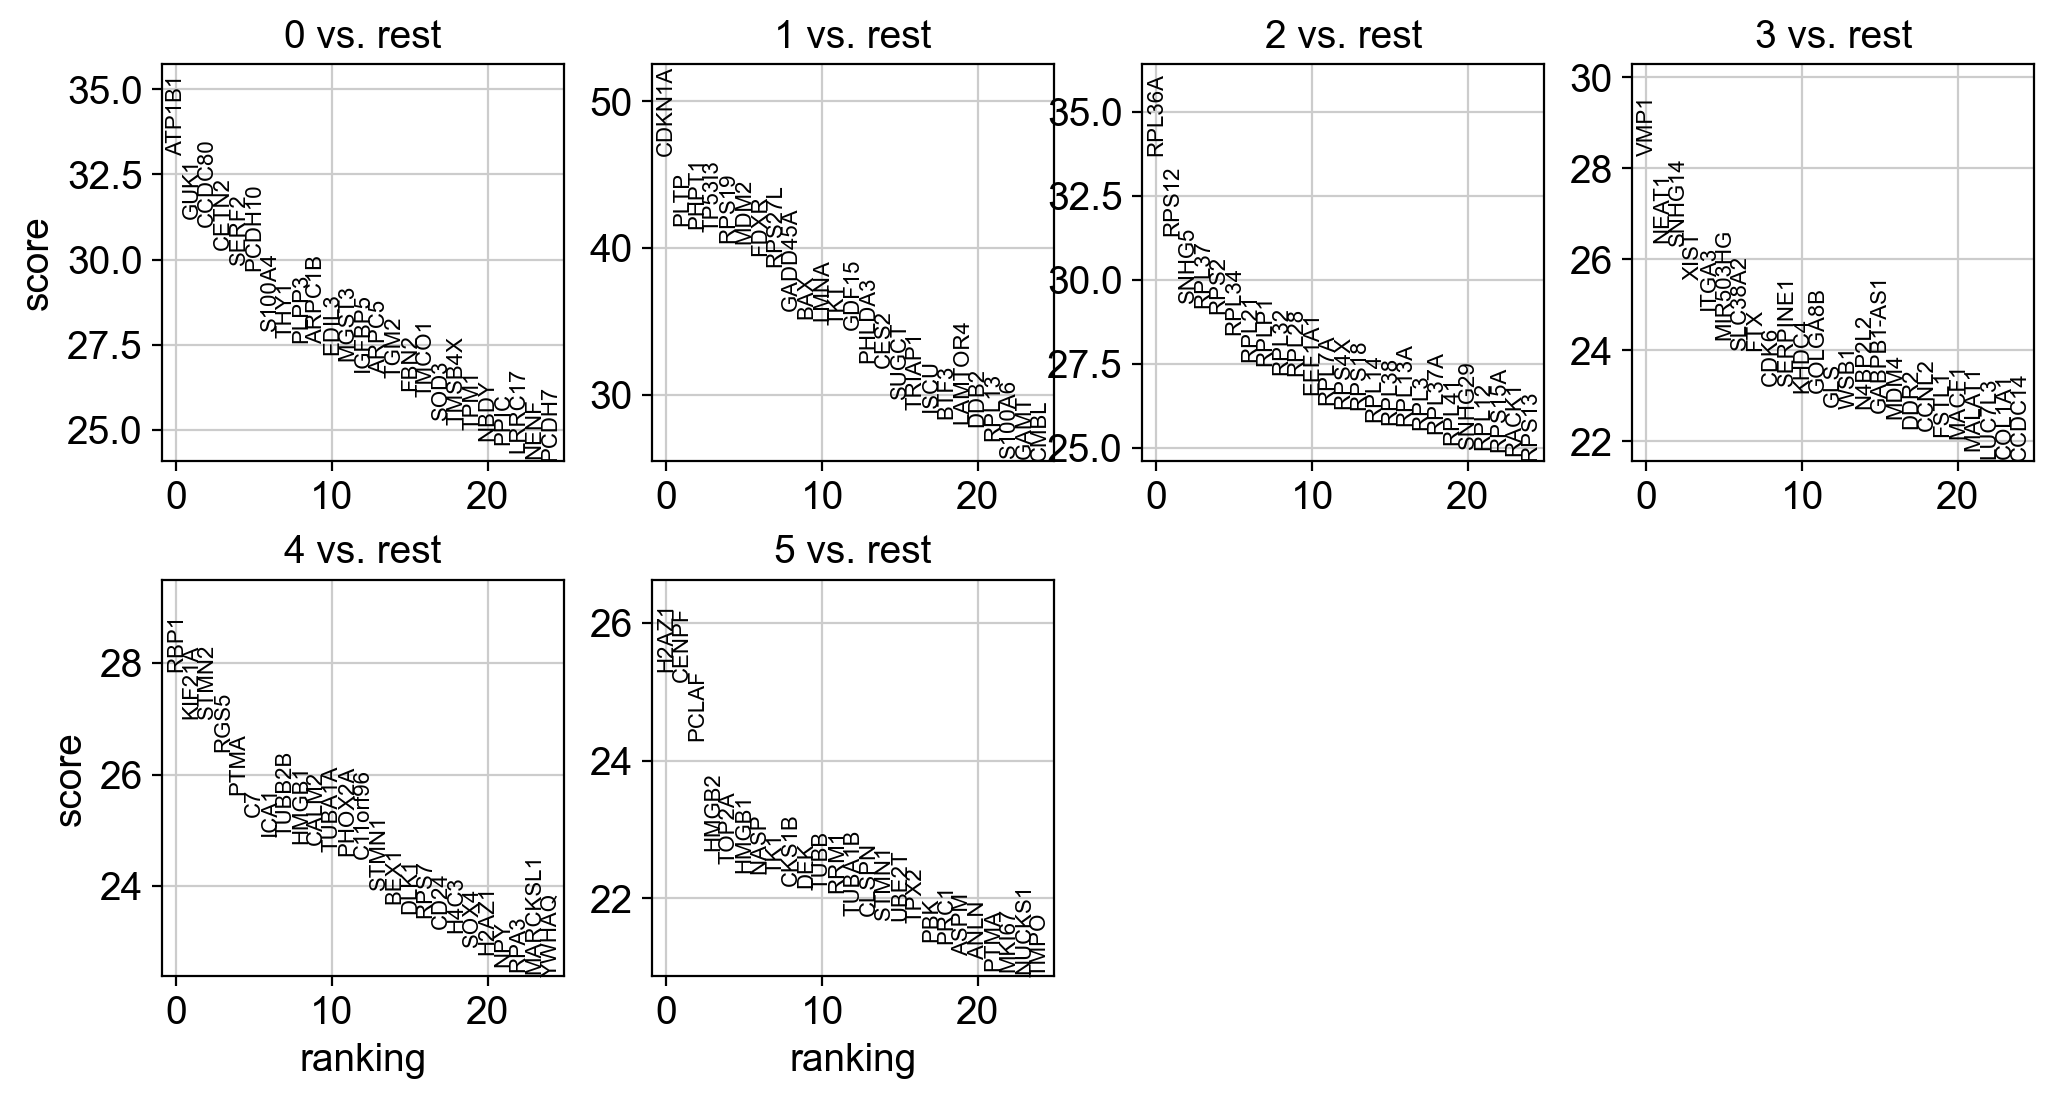

In [18]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## Mutrans analysis
See: https://github.com/cliffzhou92/MuTrans-release

In [19]:
sc.tl.tsne(adata, n_pcs = 30)

In [20]:
sc.pp.neighbors(adata, metric='cosine', n_neighbors=60, use_rep='X')

In [21]:
gc.collect()

43724

In [22]:
# Figure 5c and Extended Data Figure 8e
par = {"choice_distance":"cosine","K_cluster":6.0,"trials":50,"weight_scale":True,"initial":"pca","reduce_large_scale":True,"reduce_num_meta_cell":1000.0} 
adata_mu = pm.dynamical_analysis(adata, par)
out = adata_mu.uns['da_out']
ind = np.argsort(np.asarray(out['perm_class']).ravel().astype(int)-1)
labels_in_meta = np.asarray(out['reduce_class']).ravel().astype(int)-1
attractor_meta = np.asarray(out['class_order']).ravel()[ind]-1
adata_mu.obs['attractor'] = [ int(attractor_meta[labels_in_meta[i]]) for i in range(len(labels_in_meta))]
entropy_meta = np.asarray(out['H']).ravel()[ind]
adata_mu.obs['entropy'] = [entropy_meta[labels_in_meta[i]] for i in range(len(labels_in_meta))]

In [23]:
adata_mu

AnnData object with n_obs × n_vars = 4474 × 2671
    obs: 'Sample', 'Barcode', 'Batch', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.Sig', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'attractor', 'entropy'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'tsne', 'da_out', 'land'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'logcounts'
    obsp: 'distances', 'connectivities'

In [24]:
np.asarray(adata_mu.uns['da_out']['mu_hat'])

array([[0.24334368],
       [0.20219153],
       [0.40128529],
       [0.05348966],
       [0.05863778],
       [0.04105205]])

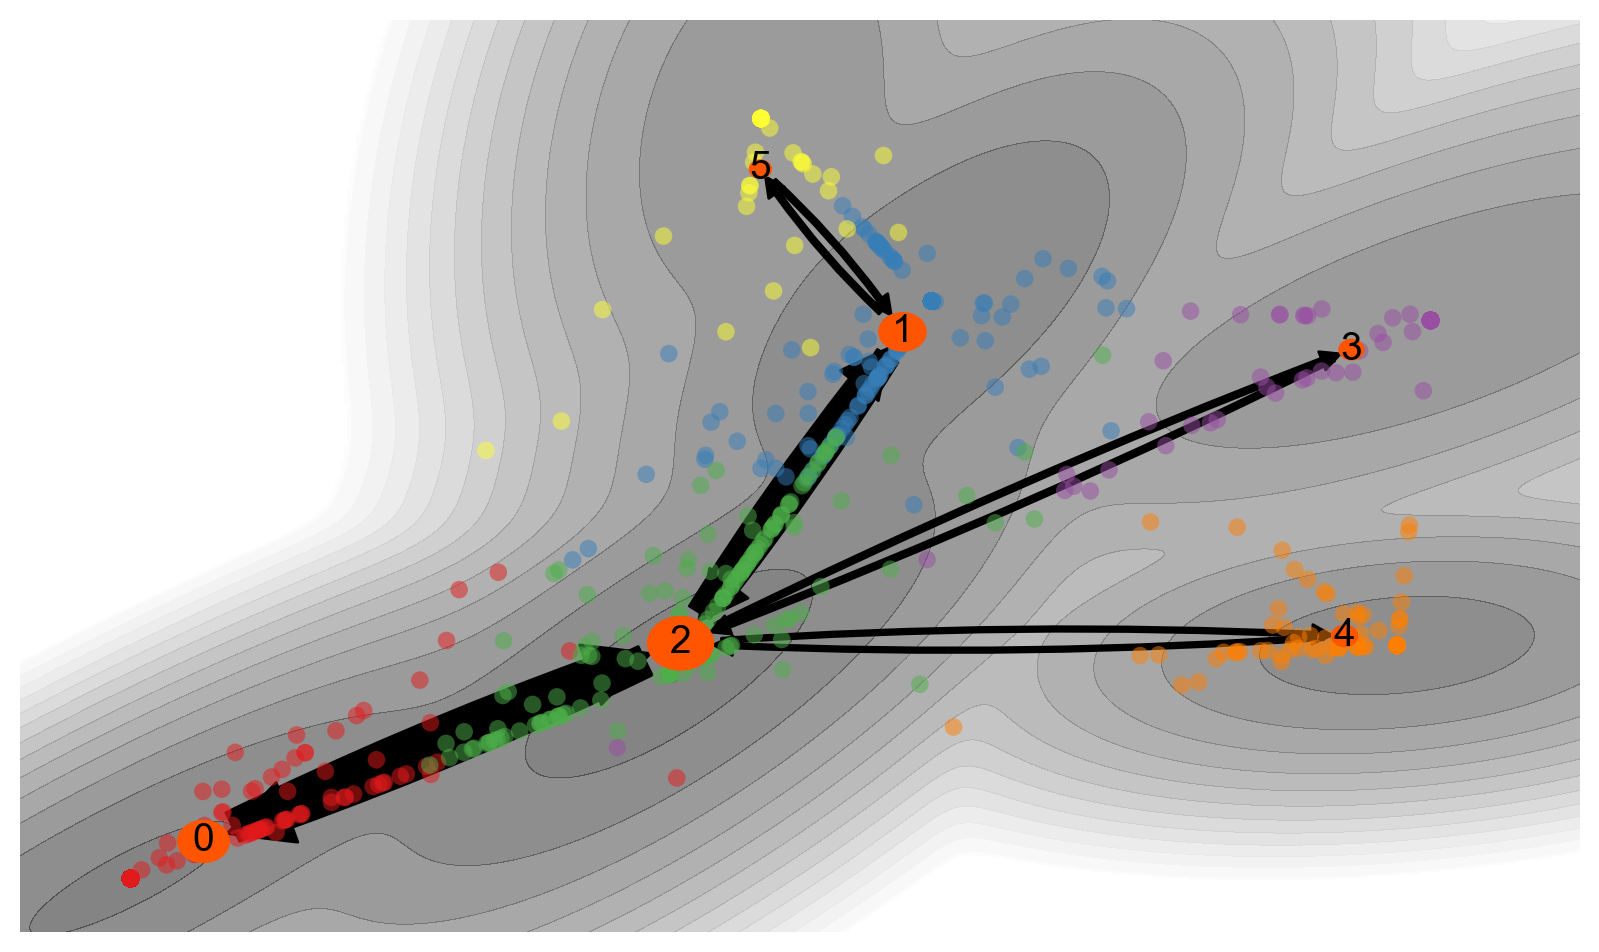

In [25]:
# Figure 5f
fig = plt.figure(figsize=(10, 6))
pm.infer_lineage(adata_mu, method = "MPFT", size_point =40, alpha_point = 0.5, size_text = 15)

MPPT 4 to 0

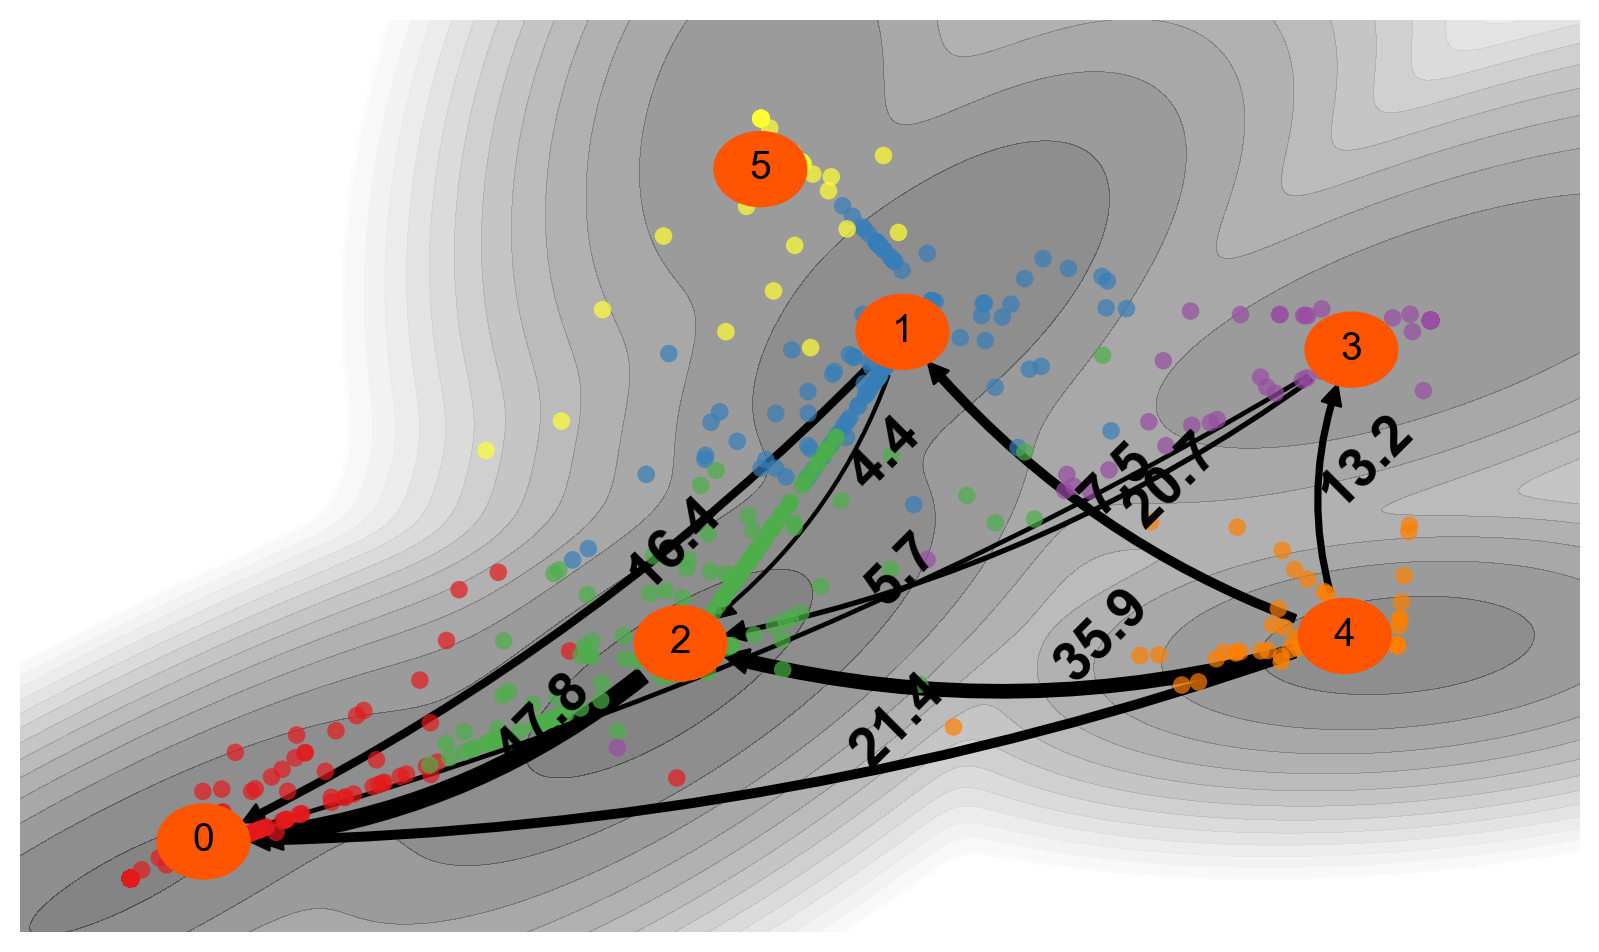

In [27]:
# Figure 5i
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si=4,sf = 0,flux_fraction=0.9,method = "MPPT",size_state = 0.2,size_point =40,size_text=20,alpha_point = 0.7)

MPPT 4 to 3

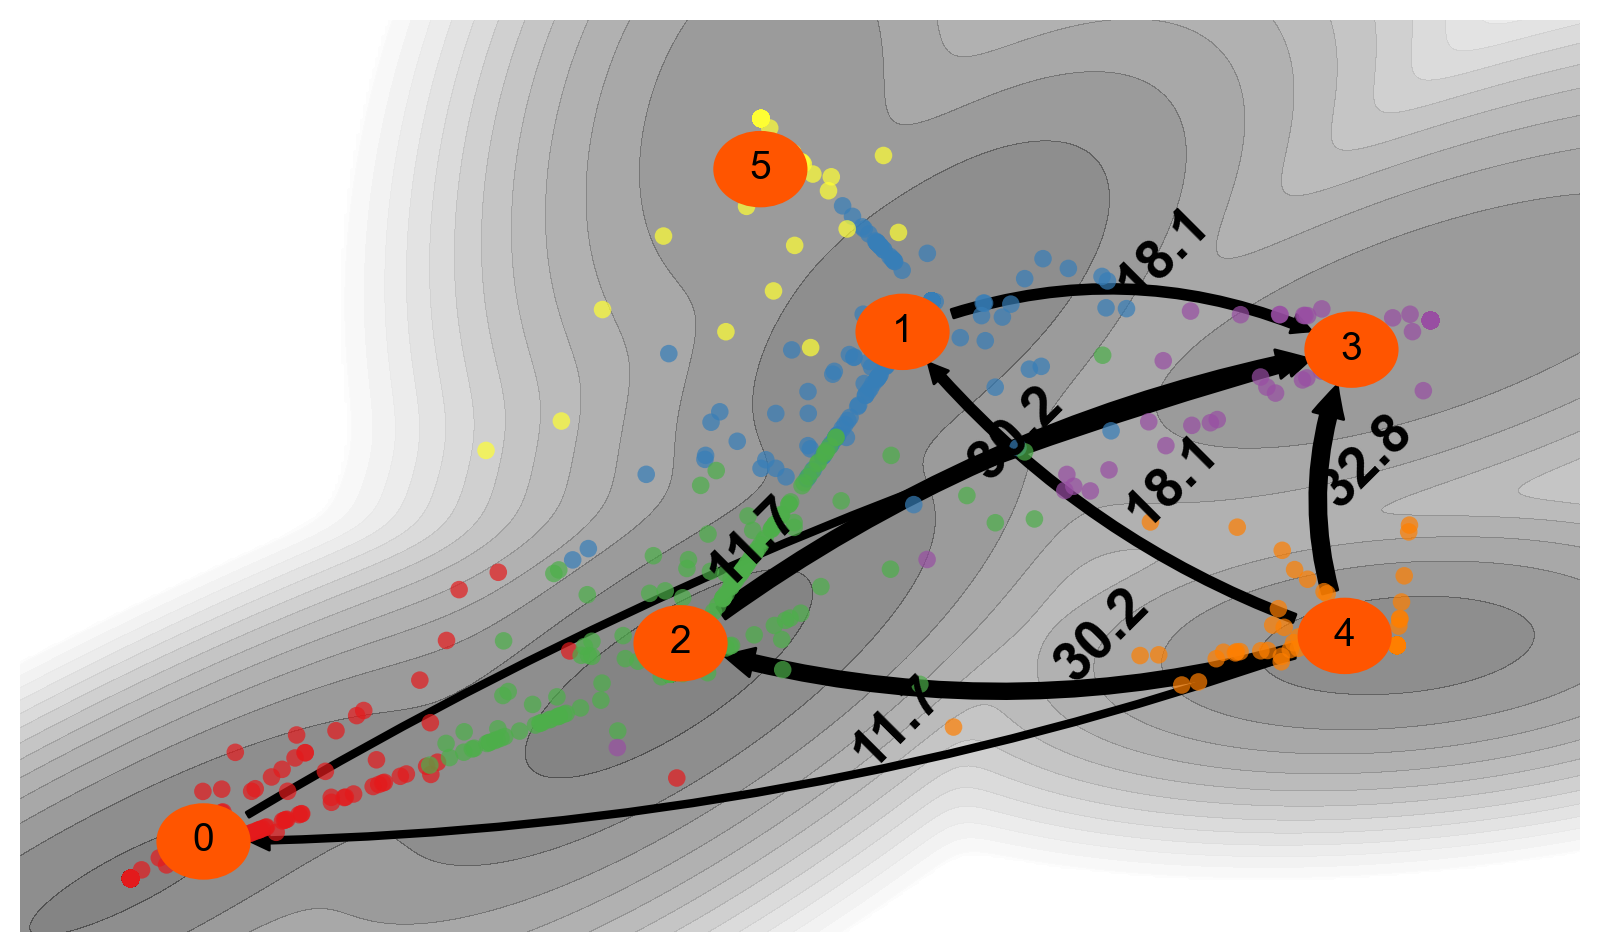

In [28]:
# Figure 5i
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si=4,sf = 3,flux_fraction=0.9,method = "MPPT",size_state = 0.2,size_point =40,size_text=20,alpha_point = 0.7)

MPPT 4 to 5

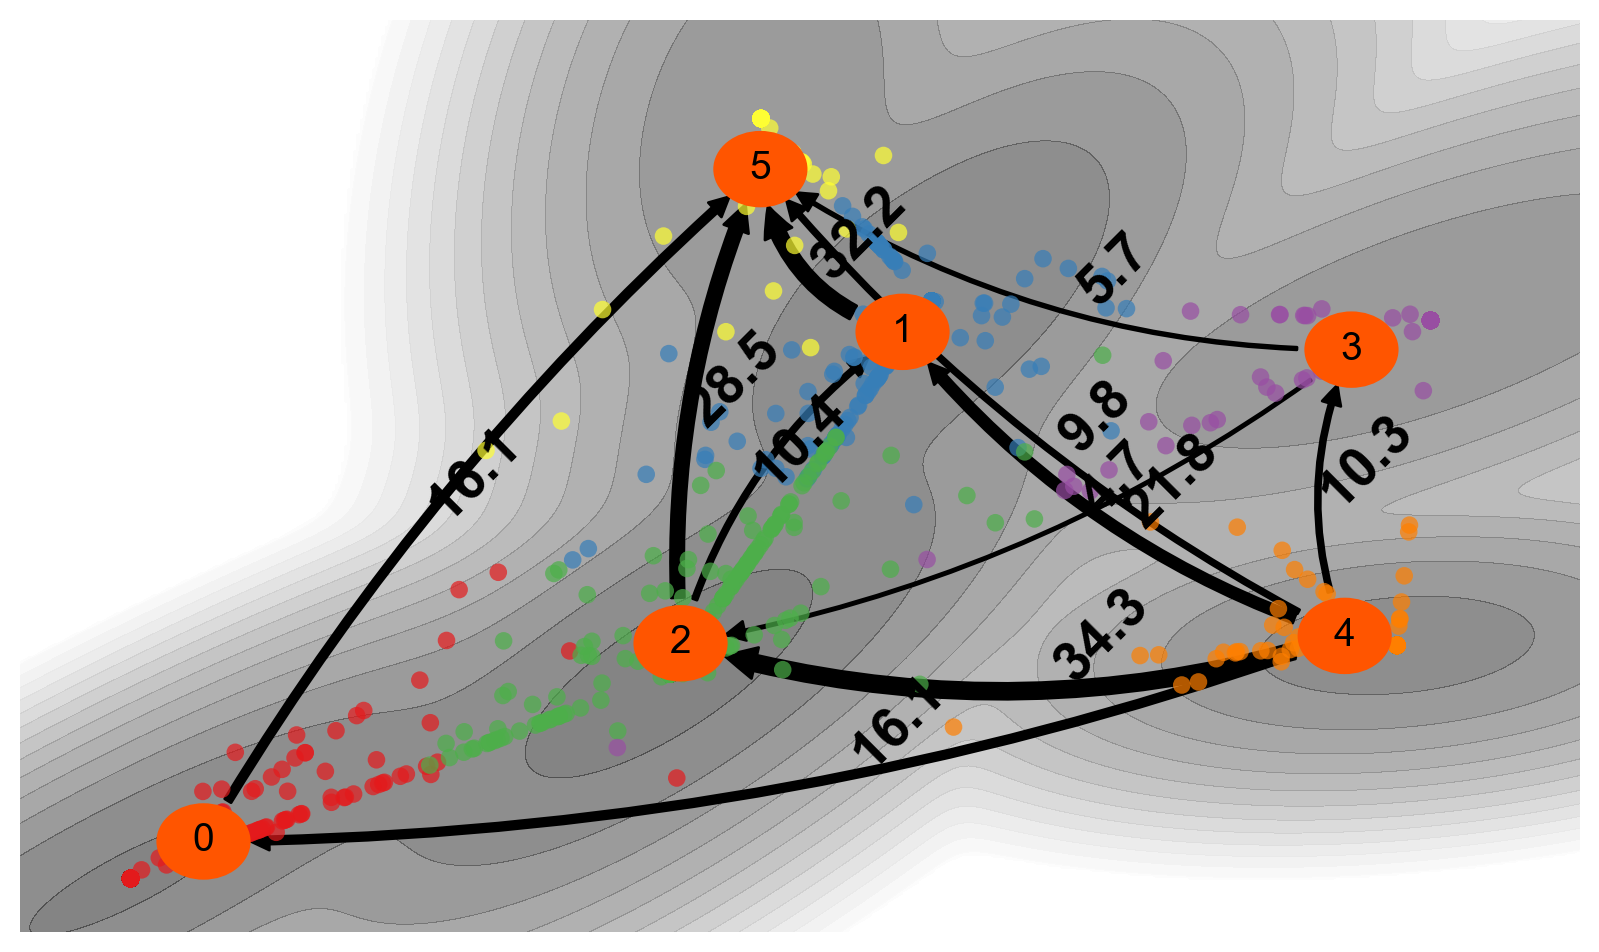

In [29]:
# Figure 5i
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si=4,sf = 5,flux_fraction=0.9,method = "MPPT",size_state = 0.2,size_point =40,size_text=20,alpha_point = 0.7)

In [30]:
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')

[<AxesSubplot:title={'center':'attractor'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'entropy'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'PHOX2B'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'PRRX1'}, xlabel='UMAP1', ylabel='UMAP2'>]

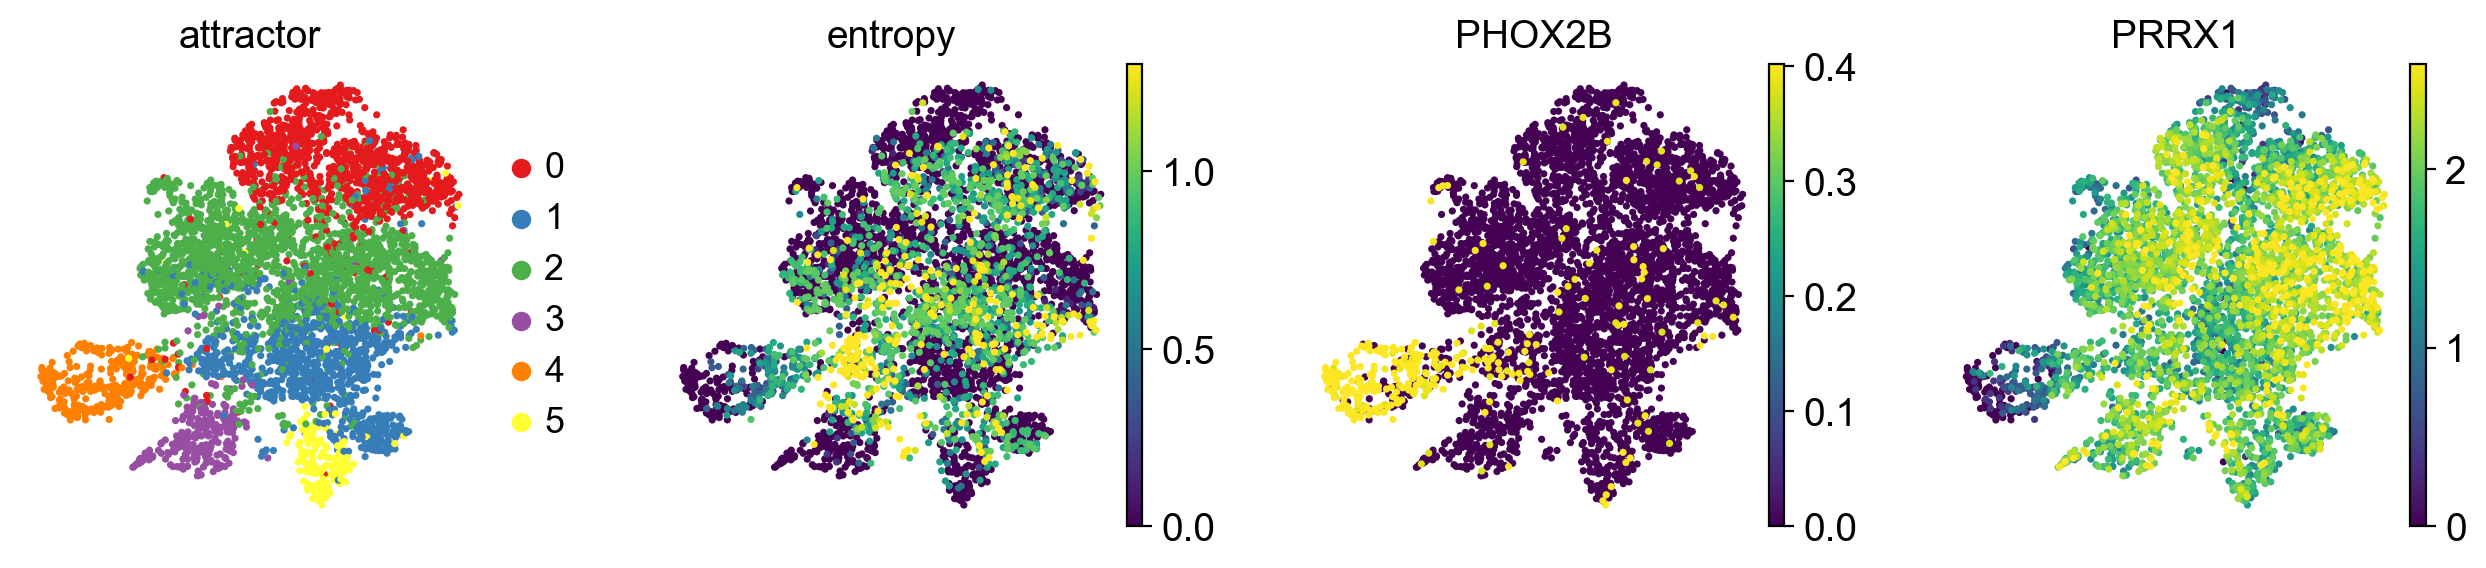

In [31]:
# Extended Data Figure 8b
color_palette = sns.color_palette('Set1', 6)
sc.pl.umap(adata_mu, color=['attractor','entropy','PHOX2B','PRRX1'], vmax = 'p95', palette = color_palette, show=False)

In [10]:
for keys in list(adata_mu.uns['da_out'].keys()):
    if type(adata_mu.uns['da_out'][keys]).__name__ == 'double':
        adata_mu.uns['da_out'][keys] = np.asarray(adata_mu.uns['da_out'][keys])    

for keys in list(adata_mu.uns['land'].keys()):
    if type(adata_mu.uns['land'][keys]).__name__ == 'double':
        adata_mu.uns['land'][keys] = np.asarray(adata_mu.uns['land'][keys])    

del adata_mu.uns['land']['model']

adata_mu.write(datadir+'cis_mutrans.h5ad')

Violin plots

In [32]:
adata_mu = sc.read(datadir+'cis_mutrans.h5ad')
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')
color_palette = sns.color_palette('Set1', 6)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [33]:
conditions = [
    adata_mu.obs['attractor'] == 0,
    adata_mu.obs['attractor'] == 1,
    adata_mu.obs['attractor'] == 2,
    adata_mu.obs['attractor'] == 3,
    adata_mu.obs['attractor'] == 4,
    adata_mu.obs['attractor'] == 5
]

outputs = [
    '2', '3', '1', '5', '4', '6'
]

In [34]:
adata_mu.obs['energy_rank'] = np.select(conditions, outputs)

In [35]:
energy_pal = {
    '1' : color_palette[2],
    '2' : color_palette[0],
    '3' : color_palette[1],
    '4' : color_palette[4],
    '5' : color_palette[3],
    '6' : color_palette[5]
}

<Axes:xlabel='energy rank', ylabel='entropy'>

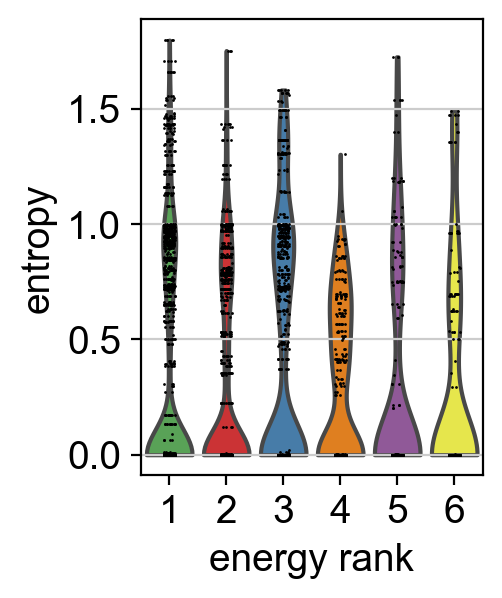

In [36]:
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
sc.pl.violin(adata_mu, keys = ['entropy'], groupby='energy_rank', show=False, palette = energy_pal)

[<Axes:xlabel='energy rank', ylabel='VIM'>,
 <Axes:xlabel='energy rank', ylabel='PHOX2B'>,
 <Axes:xlabel='energy rank', ylabel='GATA2'>,
 <Axes:xlabel='energy rank', ylabel='PRRX1'>,
 <Axes:xlabel='energy rank', ylabel='CD24'>,
 <Axes:xlabel='energy rank', ylabel='CD44'>]

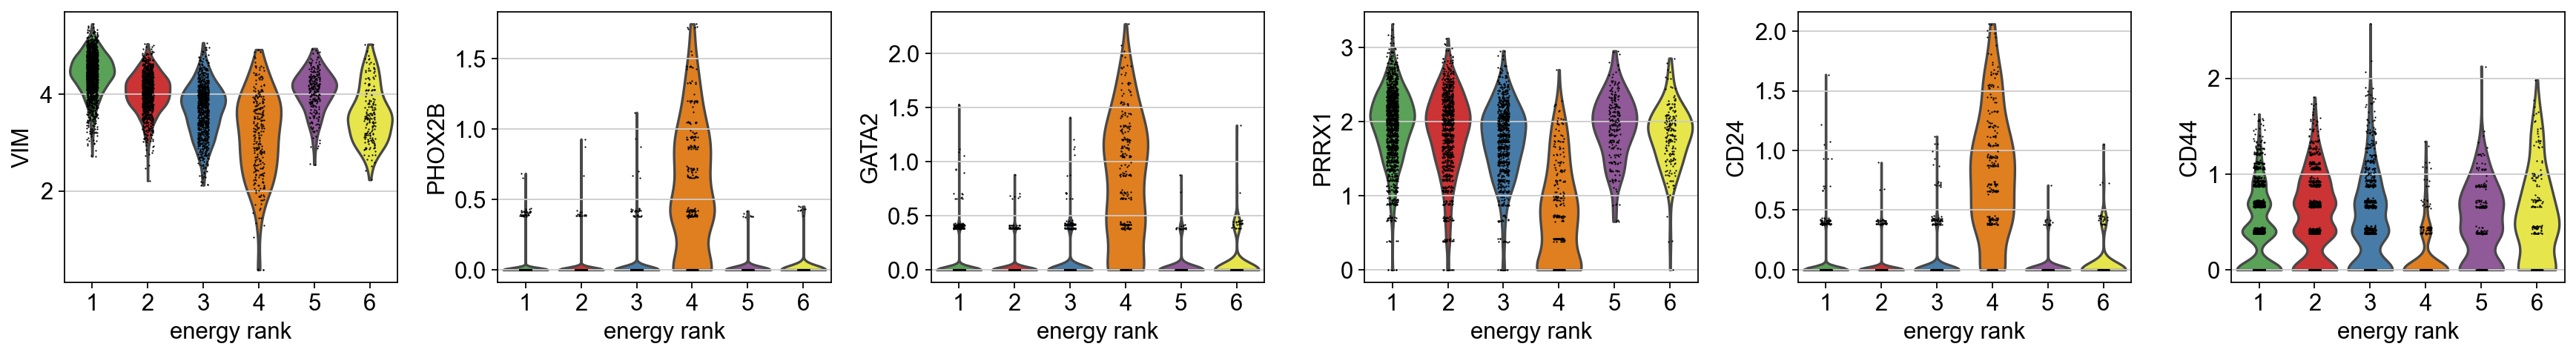

In [37]:
# Extended Data Figure 8g
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = ['VIM','PHOX2B','GATA2','PRRX1','CD24','CD44'], groupby = 'energy_rank', show=False, palette = energy_pal)